### Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_forecasting-USU/blob/main/Lectures%20and%20codes/Module%208-%20Prophet%20and%20NeuralProphet/Module8_prophet_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center)


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Rossmann Store Sales forecasting with Prophet 
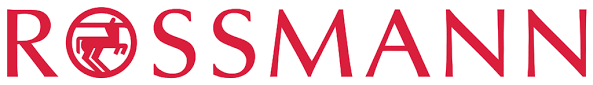


What is the Rossmann Store Sales [Dataset](https://www.kaggle.com/datasets/pratyushakar/rossmann-store-sales/data)?
- Source: It originates from a Kaggle [competition](https://www.kaggle.com/competitions/rossmann-store-sales) hosted by Rossmann, a drugstore chain in Europe.
- Task: Participants are challenged to predict daily sales for 1,115 Rossmann stores across Germany for up to six weeks in advance.
- Data: The dataset provides historical sales data, along with information about stores, promotions, holidays, and other factors potentially influencing sales.

**Readings**: 
1. Forecasting at Scale paper: https://peerj.com/preprints/3190.pdf 
2. Prophet documentation: https://facebook.github.io/prophet/docs/quick_start.html  


Citation: FlorianKnauer, Will Cukierski. (2015). Rossmann Store Sales. Kaggle. https://kaggle.com/competitions/rossmann-store-sales

## Installation

Refer to the Prophet documentation for the most up-to-date installation guide: https://facebook.github.io/prophet/docs/quick_start.html


In [2]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Importing Dataset

Download the dataset from [here](https://www.kaggle.com/datasets/pratyushakar/rossmann-store-sales/data)! or directly import from my GitHub repository! 

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/Rossmann/train.csv')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


- Store: Store ID, there is 1,115 stores in the data. we will start with store number 1 and then create a pipeline for automation
- Sales is our target variable
- Customers is another timeseries, we can combine the two and study sales per customer! 
- Open: whether or not store is open
- Promo: wheter or not store has promo
- StateHoliday/SchoolHoliday: time indicator variables

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [6]:
# value counts of the store
df['Store'].value_counts().sort_index()

Store
1       942
2       942
3       942
4       942
5       942
       ... 
1111    942
1112    942
1113    942
1114    942
1115    942
Name: count, Length: 1115, dtype: int64

In [7]:
# Creating a new dataframe for store 1
store1 = df[df['Store']==1]
store1.set_index('Date', inplace=True)  
store1.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


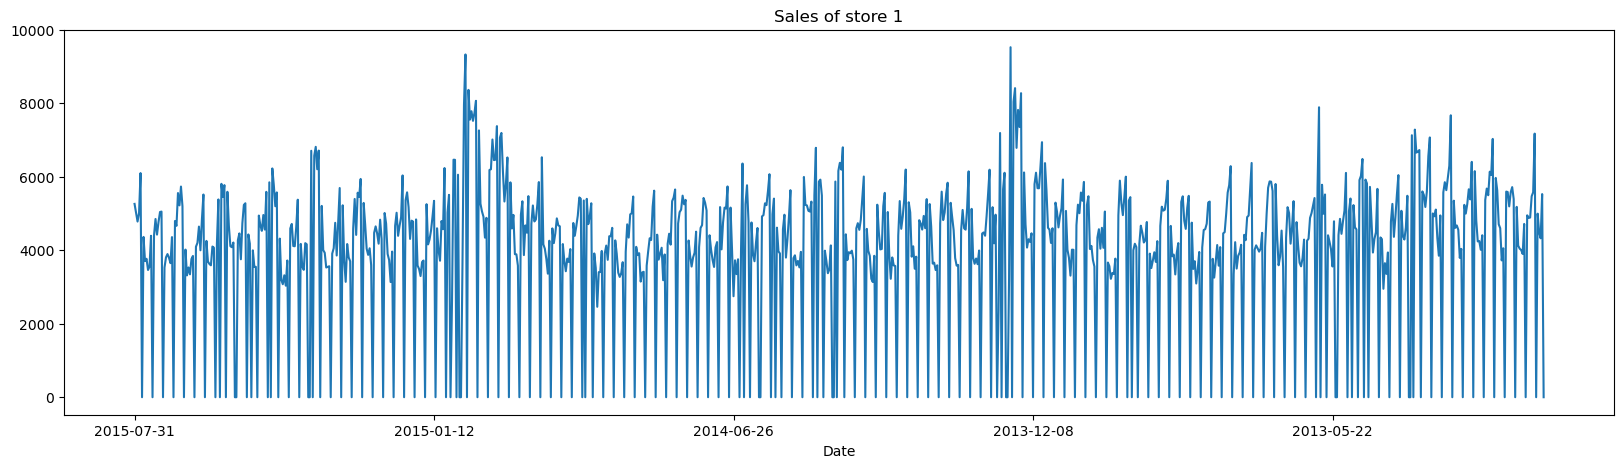

In [8]:
# plotting the sales of store 1 
store1['Sales'].plot(figsize=(20,5))
plt.title('Sales of store 1')
plt.show()


As you can see, sales goes down to zero frequency. This must have something to do with if the store is open or not! 

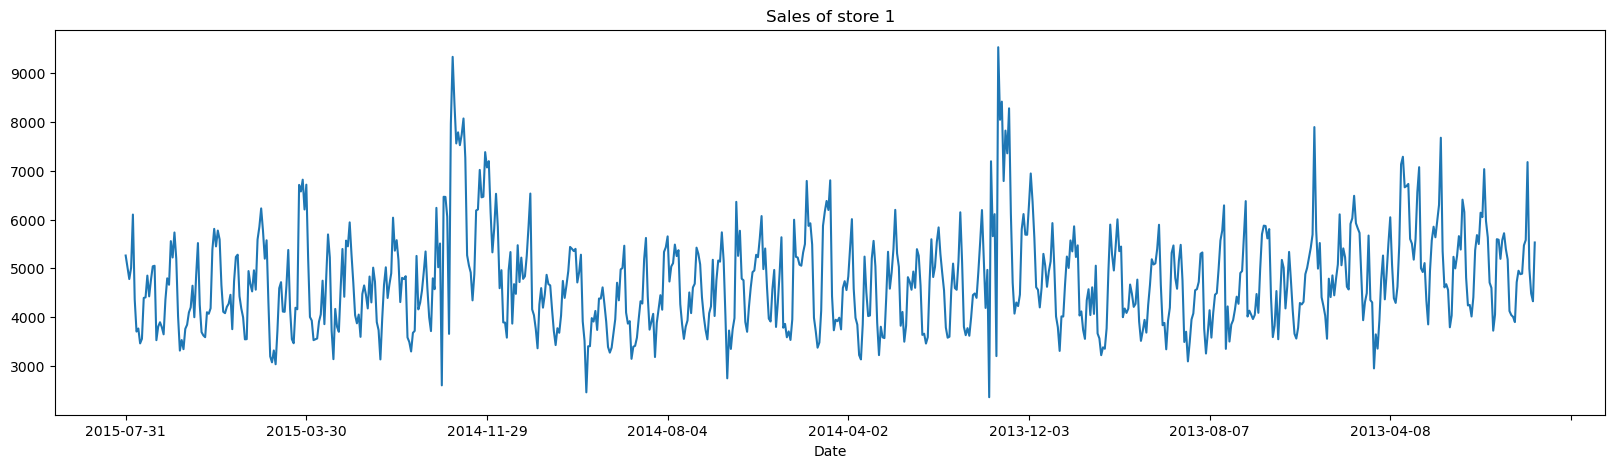

In [9]:
# plotting the sales for the open days only
store1_open = store1[store1['Open']==1]
store1_open['Sales'].plot(figsize=(20,5))
plt.title('Sales of store 1')
plt.show()


In [11]:
store1_open.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


### Preparing data for prophet
The input to Prophet is always a dataframe with two columns: **ds** and **y**. 

- The **ds** (datestamp) column should be of a format expected by Pandas, ideally **YYYY-MM-DD** for a date or **YYYY-MM-DD HH:MM:SS** for a timestamp. 
- The y column must be numeric, and represents the measurement we wish to forecast.

In [12]:
# we can sort the store1 index into chronological order
store1_open = store1_open.sort_index()
df_prophet = store1_open.reset_index()[['Date', 'Sales']].rename({'Date':'ds', 'Sales':'y'}, axis='columns')
df_prophet.head(10)

,ds,y
0,2013-01-02,5530
1,2013-01-03,4327
2,2013-01-04,4486
3,2013-01-05,4997
4,2013-01-07,7176
5,2013-01-08,5580
6,2013-01-09,5471
7,2013-01-10,4892
8,2013-01-11,4881
9,2013-01-12,4952


Note: Due to it's non-recursive nature (the only regressor is time), Prophet can handle missing data easily, we don't need to interpolate values for store close dates. We can simply remove them from the data!

In [13]:
df_prophet.tail()

,ds,y
776,2015-07-27,6102
777,2015-07-28,5011
778,2015-07-29,4782
779,2015-07-30,5020
780,2015-07-31,5263


## Prophet Base Model

In [14]:
m1 = Prophet()
m1.fit(df_prophet)

10:40:27 - cmdstanpy - INFO - Chain [1] start processing
10:40:28 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
future = m1.make_future_dataframe(periods=365)
future.head(10)

,ds
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-07
5,2013-01-08
6,2013-01-09
7,2013-01-10
8,2013-01-11
9,2013-01-12


In [16]:
forecast = m1.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1141,2016-07-26,4639.221422,3344.683869,5525.946952,4579.024659,4696.299390,-234.216316,-234.216316,-234.216316,-102.668751,-102.668751,-102.668751,-131.547565,-131.547565,-131.547565,0.0,0.0,0.0,4405.005107
1142,2016-07-27,4639.122458,3189.356469,5318.608685,4578.722698,4696.401120,-371.486222,-371.486222,-371.486222,-219.647723,-219.647723,-219.647723,-151.838498,-151.838498,-151.838498,0.0,0.0,0.0,4267.636236
1143,2016-07-28,4639.023493,3079.576592,5231.079692,4578.420737,4696.410130,-484.021824,-484.021824,-484.021824,-309.089654,-309.089654,-309.089654,-174.932170,-174.932170,-174.932170,0.0,0.0,0.0,4155.001669
1144,2016-07-29,4638.924529,3315.863338,5477.197233,4578.139726,4696.371145,-254.840361,-254.840361,-254.840361,-54.528538,-54.528538,-54.528538,-200.311824,-200.311824,-200.311824,0.0,0.0,0.0,4384.084167
1145,2016-07-30,4638.825564,3456.361767,5637.085133,4577.863304,4696.505356,-76.706535,-76.706535,-76.706535,150.703305,150.703305,150.703305,-227.409840,-227.409840,-227.409840,0.0,0.0,0.0,4562.119029


**yhat**: The final forecasted value, which is the sum of the trend and additive_terms (seasonal components + holiday effects), plus any multiplicative adjustments if applicable

In [31]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1141,2016-07-26,4405.005107,3405.332776,5439.962147
1142,2016-07-27,4267.636236,3169.494966,5423.949527
1143,2016-07-28,4155.001669,3099.687897,5171.291897
1144,2016-07-29,4384.084167,3322.813627,5535.145658
1145,2016-07-30,4562.119029,3399.423050,5671.990230


Note: we will ignore the predictions for Sundays. Simply because the stores are close on sundays. 
since we don't have data on Sundays, the model is simply interpolating. 

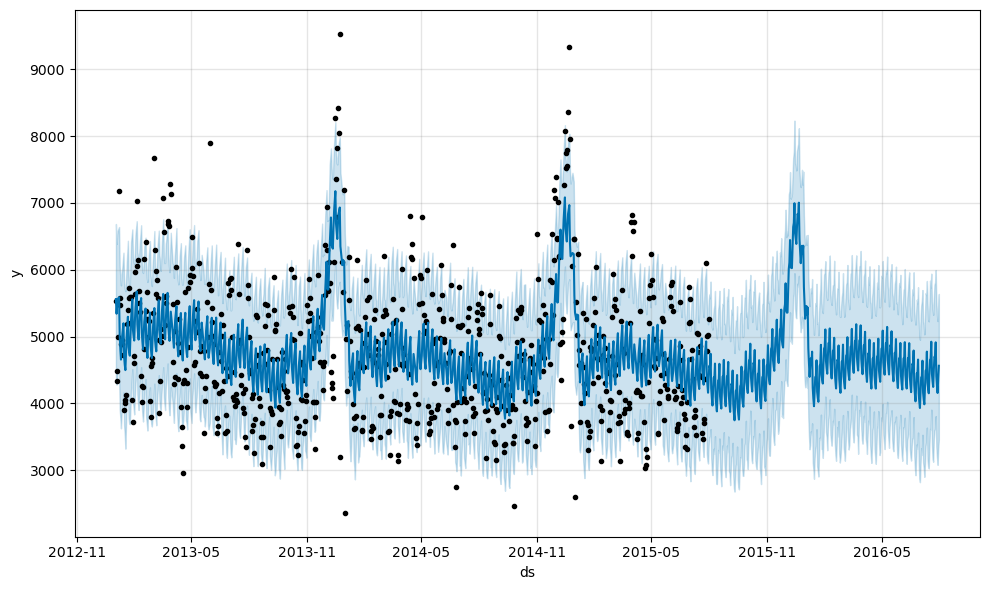

In [17]:
fig1 = m1.plot(forecast)

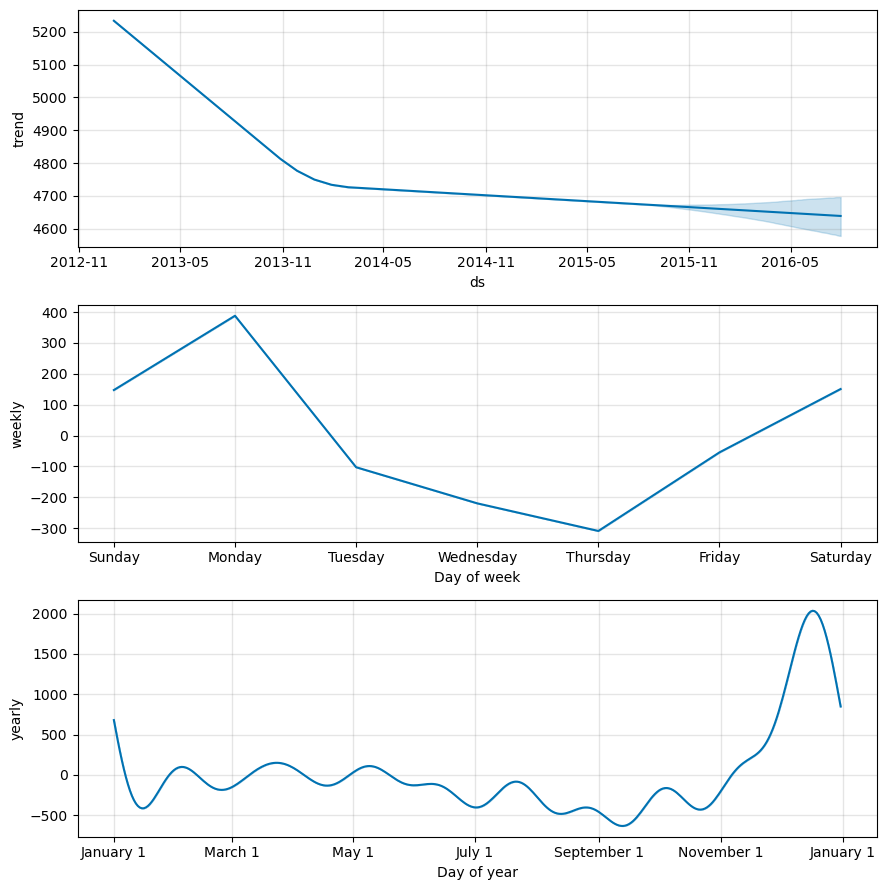

In [18]:
fig1_c = m1.plot_components(forecast)

## Prophet Custom Model

Recall: 

### Changepoints 

Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately. However, if you wish to have finer control over this process (e.g., Prophet missed a rate change, or is overfitting rate changes in the history), then there are several input arguments you can use.

* Prior $\delta$ ~ LaPlace(0, $\tau$)
* Parameter Description: *changepoint_prior_scale*: $\tau$ controls the flexibility of the trend at changepoints. It is the scale parameter for the prior distribution of the rate at which the trend changes.
* Numerical Example: If you're forecasting sales around multiple new product launches, an increase in $\tau$ makes the model more responsive to these events. For example, setting $\tau=0.1$  rather than a more conservative value like 0.05 allows the model to detect and adapt to changes more aggressively.

By default changepoints are only inferred for the first 80% of the time series in order to have plenty of runway for projecting the trend forward and to avoid overfitting fluctuations at the end of the time series. This default works in many situations but not all, and can be changed using the *changepoint_range* argument.

If you wish, rather than using automatic changepoint detection you can manually specify the locations of potential changepoints with the [changepoints](https://facebook.github.io/prophet/docs/trend_changepoints.html#specifying-the-locations-of-the-changepoints) argument!


### Seasonality 

Seasonalities are estimated using a partial Fourier sum. See the paper for complete details, and this [figure on Wikipedia ](https://en.wikipedia.org/wiki/Fourier_series#/media/File:Fourier_Series.svg)for an illustration of how a partial Fourier sum can approximate an arbitrary periodic signal. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change. 

* Smoothing Prior on seasonality $\beta$ ~ N(0, $\sigma^2$)
* Parameter Description: *seasonality_prior_scale* $\sigma$ affects how strongly the model fits the seasonal pattern of the data. It is used as the scale of the prior distribution for seasonal effects.
* Numerical Example: For a business with highly seasonal sales, such as a holiday store, emphasizing seasonal effects may be beneficial. Increasing $\sigma$ to a higher value, such as 15, can accentuate the seasonal components, capturing more pronounced seasonal fluctuations.

There are many other ways you can customize seasonalities. Check out the documentation [here](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html). 

### Holidays 

If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them. It has two columns (holiday and ds) and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data go) and in the future (out as far as the forecast is being made). If they won’t repeat in the future, Prophet will model them and then not include them in the forecast.

You can also include columns lower_window and upper_window which extend the holiday out to [lower_window, upper_window] days around the date. For instance, if you wanted to include Christmas Eve in addition to Christmas you’d include lower_window=-1,upper_window=0. If you wanted to use Black Friday in addition to Thanksgiving, you’d include lower_window=0,upper_window=1. You can also include a column prior_scale to set the prior scale separately for each holiday. 


* Prior $\kappa$ ~ N(0, $\gamma^2$)
* Parameter Description: $\gamma$ impacts how significantly holidays affect the forecast. It determines the flexibility of the model in adjusting for holiday effects.


There are many other ways you can customize Holidays. Check out the documentation [here](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html). 

In [19]:
# recall store1 is the data with and without the open days. Store1_open is the data with only the open days
store1_open.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1
2013-01-07,1,1,7176,785,1,1,0,1


In [20]:
# finding the unique values for StateHoliday
print(store1['StateHoliday'].unique())
print(store1_open['StateHoliday'].unique())    

['0' 'a' 'b' 'c' 0]
['0' 0]


Note: For StateHoliday, '0' means no holiday, 'a' means public holiday, 'b' means Easter, and 'c' means Christmas. 
- when we work with store1_open data, we already take care of all these holidays, so we don't need to add them manually. 

In [22]:
# finding the unique values for SchoolHoliday
print(store1['SchoolHoliday'].unique())
print(store1_open['SchoolHoliday'].unique())


[1 0]
[1 0]


Here for SchoolHoliday, it seems that we need to manually add them as dummy variabes (new regressor) to our prophet dataset. 

In [23]:
# Adding SchoolHoliday data to the df_prophet dataframe
df_prophet['SchoolHoliday'] = store1_open['SchoolHoliday'].values

# Adding promo data to the df_prophet dataframe as well. This is used to model the effect of promotions on sales
df_prophet['Promo'] = store1_open['Promo'].values

df_prophet.head()

,ds,y,SchoolHoliday,Promo
0,2013-01-02,5530,1,0
1,2013-01-03,4327,1,0
2,2013-01-04,4486,1,0
3,2013-01-05,4997,1,0
4,2013-01-07,7176,1,1


In [24]:
m2 = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.8, seasonality_mode='additive', seasonality_prior_scale=10) # using default values for now

m2.add_country_holidays(country_name='DE') # remember, we didn't need to do this step if we were using the open days only. 
m2.add_regressor('SchoolHoliday', mode='additive')
m2.add_regressor('Promo', mode='additive')

m2.fit(df_prophet)

11:29:23 - cmdstanpy - INFO - Chain [1] start processing
11:29:23 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
future2 = m2.make_future_dataframe(periods=365)
future2.head()

,ds
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-07


In [26]:
# print df_prophet and future2 shapes
print(df_prophet.shape)
print(future2.shape)

(781, 4)
(1146, 1)


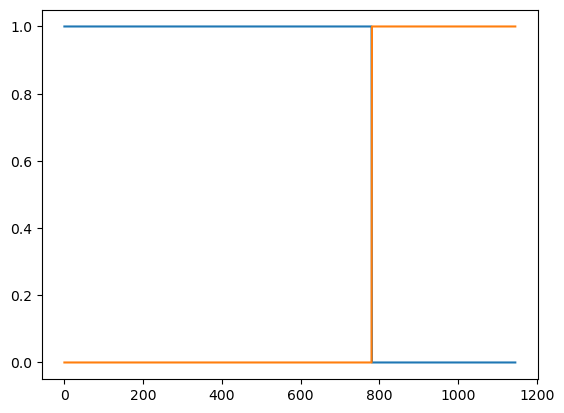

In [27]:
# Let's create a train and forecast index for the future2 dataframe

train_index = future2['ds'].isin(df_prophet['ds'])
forecast_index = ~train_index

# plot the train index and test index to see the split
plt.plot(train_index)
plt.plot(forecast_index)
plt.show()


In [28]:
# Adding the extra regressors to the future2 dataframe since we need them for the forecast
# For train set it is easy! We just need to add the regressors to the future2 dataframe

future2.loc[train_index, 'SchoolHoliday'] = df_prophet['SchoolHoliday'].values
future2.loc[train_index, 'Promo'] = df_prophet['Promo'].values

future2.head()

,ds,SchoolHoliday,Promo
0,2013-01-02,1.0,0.0
1,2013-01-03,1.0,0.0
2,2013-01-04,1.0,0.0
3,2013-01-05,1.0,0.0
4,2013-01-07,1.0,1.0


In [29]:
# Now we need to add these two regressors to the forecast dataframe as well
# we will use the last known values in the past 365 days from the store1 dataframe. Why not store1_open? 
store1 = store1.sort_index()
store1.head()


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1


In [30]:
store1_open.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1
2013-01-07,1,1,7176,785,1,1,0,1


In [31]:
future2.loc[forecast_index, 'SchoolHoliday'] = store1.iloc[-365:]['SchoolHoliday'].values
future2.loc[forecast_index, 'Promo'] = store1.iloc[-365:]['Promo'].values

future2.tail(10)

,ds,SchoolHoliday,Promo
1136,2016-07-21,0.0,0.0
1137,2016-07-22,0.0,0.0
1138,2016-07-23,0.0,0.0
1139,2016-07-24,0.0,0.0
1140,2016-07-25,0.0,0.0
1141,2016-07-26,1.0,1.0
1142,2016-07-27,1.0,1.0
1143,2016-07-28,1.0,1.0
1144,2016-07-29,1.0,1.0
1145,2016-07-30,1.0,1.0


In [32]:
future2.head()

,ds,SchoolHoliday,Promo
0,2013-01-02,1.0,0.0
1,2013-01-03,1.0,0.0
2,2013-01-04,1.0,0.0
3,2013-01-05,1.0,0.0
4,2013-01-07,1.0,1.0


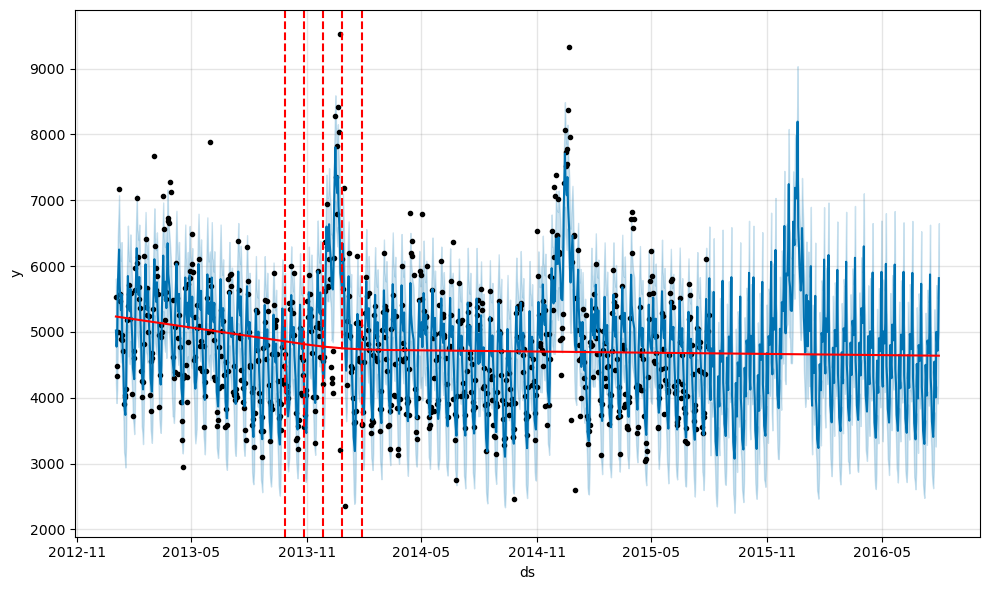

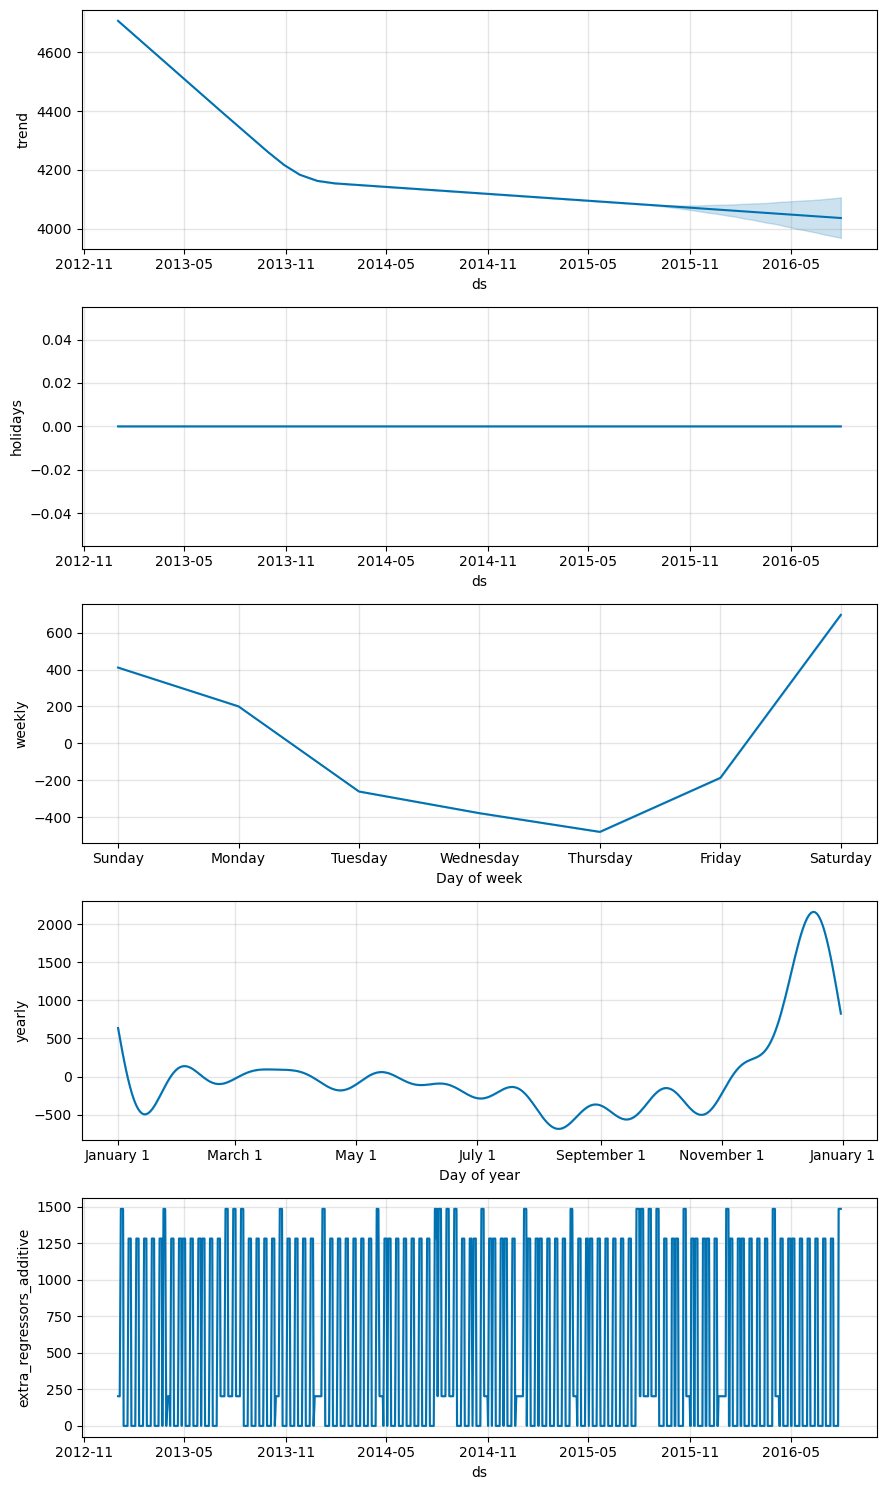

In [33]:
forecast2 = m2.predict(future2)
fig2 = m2.plot(forecast2)
a = add_changepoints_to_plot(fig2.gca(), m2, forecast)

fig2_c = m2.plot_components(forecast2)


In [34]:
m2.train_holiday_names

0             New Year's Day
1                Good Friday
2              Easter Monday
3                  Labor Day
4              Ascension Day
5                Whit Monday
6           German Unity Day
7              Christmas Day
8    Second Day of Christmas
dtype: object

## Model Evaluations & Diagnostics

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). 
* By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.


In the Prophet library for Python, when performing cross-validation, the initial, period, and horizon parameters are expected to be strings that represent a duration and these durations should be specified in days rather than months because not all months have the same number of days.

In [35]:
# Initial 2 years training period
initial = 2 * 365
initial = str(initial) + ' days'

# Roll every 30 days
period = 30
period = str(period) + ' days'

# Forecast 6 weeks into the future
horizon = 42
horizon = str(horizon) + ' days'

print("initial: ", initial)
print("period: ", period)
print("horizon: ", horizon)

initial:  730 days
period:  30 days
horizon:  42 days


In [36]:
df_cv_m2 = cross_validation(m2, initial=initial, period=period, horizon=horizon)

  0%|          | 0/6 [00:00<?, ?it/s]12:16:25 - cmdstanpy - INFO - Chain [1] start processing
12:16:25 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:00,  5.46it/s]12:16:25 - cmdstanpy - INFO - Chain [1] start processing
12:16:25 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:00,  5.70it/s]12:16:25 - cmdstanpy - INFO - Chain [1] start processing
12:16:25 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:00<00:00,  6.38it/s]12:16:25 - cmdstanpy - INFO - Chain [1] start processing
12:16:25 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:00<00:00,  6.74it/s]12:16:25 - cmdstanpy - INFO - Chain [1] start processing
12:16:25 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:00<00:00,  6.70it/s]12:16:25 - cmdstanpy - INFO - Chain [1] start processing
12:16:25 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:00<00:00,  6.53it/s]


In [37]:
df_cv_m2

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-01-21,3496.156671,2641.071048,4299.077095,3299,2015-01-20
1,2015-01-22,3437.636993,2621.297639,4266.904207,3492,2015-01-20
2,2015-01-23,3833.565811,3036.214852,4603.414354,3586,2015-01-20
3,2015-01-24,4754.511998,3976.892715,5525.826575,4840,2015-01-20
4,2015-01-26,5703.881425,4919.877624,6560.536874,4781,2015-01-20
...,...,...,...,...,...,...
203,2015-07-27,5480.935467,4724.211686,6268.317555,6102,2015-06-19
204,2015-07-28,4979.784587,4194.457877,5797.008883,5011,2015-06-19
205,2015-07-29,4830.052270,4058.649886,5654.776052,4782,2015-06-19
206,2015-07-30,4676.879631,3919.072035,5495.976789,5020,2015-06-19


* cutoff is where we started the forecast from
* ds is the timestamp for the forecasted value

In [38]:
m2_metrics = performance_metrics(df_cv_m2, rolling_window=0.1) # default is 0.1
m2_metrics

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,202749.469757,450.277103,372.476521,0.100337,0.080670,0.093678,0.950000
1,5 days,140779.884326,375.206456,316.061808,0.084204,0.070404,0.080457,0.990000
2,6 days,146534.703850,382.798516,322.148493,0.082988,0.070404,0.080990,0.950000
3,7 days,173270.218022,416.257394,359.419520,0.088226,0.087039,0.088085,0.950000
4,8 days,259202.087957,509.118933,448.636837,0.104593,0.095719,0.106024,0.850000
5,9 days,394023.445989,627.712869,550.758928,0.117817,0.127274,0.121890,0.710000
6,10 days,548371.607576,740.521173,629.021119,0.123976,0.136082,0.131298,0.600000
7,11 days,722927.715791,850.251560,710.692265,0.130974,0.163231,0.140645,0.500000
8,12 days,848566.345959,921.176610,764.507479,0.130731,0.142311,0.143272,0.480000
9,13 days,808805.975209,899.336408,733.276584,0.123630,0.106969,0.135788,0.540000


**Important**: Since the Horizon is 42 days, and the default moving average windows is 10% of Horizon (i.e 4 days), the first value starts from 4 days. 
we can change the rolling window like this: *performance_metrics(df_cv, rolling_window=1)*

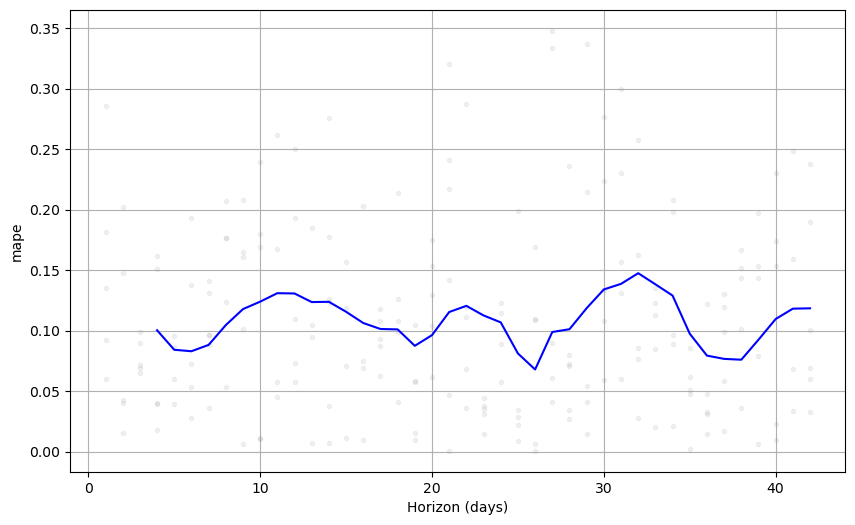

In [39]:
plot_cross_validation_metric(df_cv_m2, metric='mape');


  0%|          | 0/6 [00:00<?, ?it/s]12:17:59 - cmdstanpy - INFO - Chain [1] start processing
12:17:59 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:00,  8.24it/s]12:17:59 - cmdstanpy - INFO - Chain [1] start processing
12:17:59 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:00,  8.41it/s]12:17:59 - cmdstanpy - INFO - Chain [1] start processing
12:17:59 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:00<00:00,  8.61it/s]12:17:59 - cmdstanpy - INFO - Chain [1] start processing
12:17:59 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:00<00:00,  8.40it/s]12:18:00 - cmdstanpy - INFO - Chain [1] start processing
12:18:00 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:00<00:00,  8.50it/s]12:18:00 - cmdstanpy - INFO - Chain [1] start processing
12:18:00 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:00<00:00,  8.45it/s]


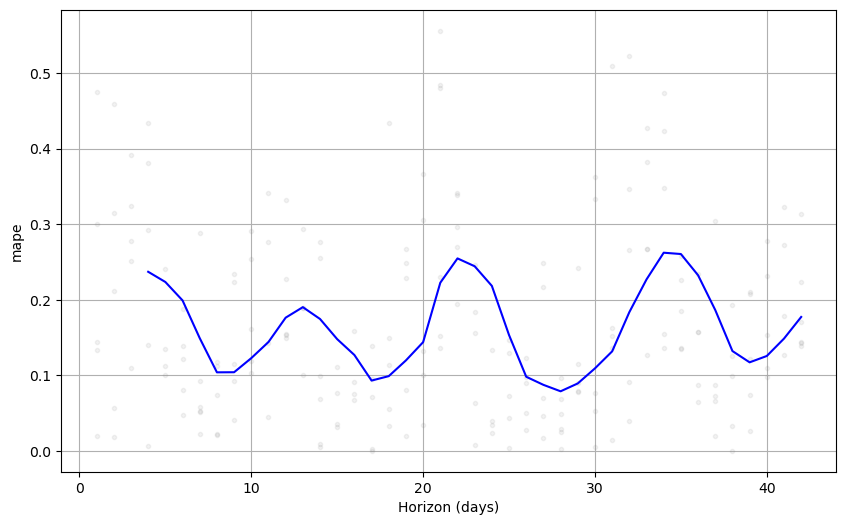

In [40]:
# we can repeat the cross validation for the m1 model
df_cv_m1 = cross_validation(m1, initial=initial, period=period, horizon=horizon)
m1_metrics = performance_metrics(df_cv_m1)
plot_cross_validation_metric(df_cv_m1, metric='mape');

In [41]:
# now we can compare the performance of the two models, m1 without regressors and m2 with regressors
# we can compare the mape, rmse, mse, mae, mdape, smape, coverage, and coverage of the two models
# we can also compare the mean and std of the metrics

model1 = pd.DataFrame(m1_metrics.drop(columns=['horizon']).mean().round(3), columns=['m1_base_model_mean'])
model1['m1_base_model_std'] = pd.DataFrame(m1_metrics.drop(columns=['horizon']).std().round(3))
model1.T


,mse,rmse,mae,mape,mdape,smape,coverage
m1_base_model_mean,740960.388,831.499,696.443,0.162,0.142,0.153,0.783
m1_base_model_std,379645.937,225.555,211.587,0.055,0.061,0.046,0.136


In [42]:
model2 = pd.DataFrame(m2_metrics.drop(columns=['horizon']).mean().round(3), columns=['m2_custom_model_mean'])
model2['m2_custom_model_std'] = pd.DataFrame(m2_metrics.drop(columns=['horizon']).std().round(3))
model2.T

,mse,rmse,mae,mape,mdape,smape,coverage
m2_custom_model_mean,377374.837,590.883,486.009,0.108,0.098,0.106,0.800
m2_custom_model_std,214650.119,170.220,137.618,0.020,0.028,0.021,0.151


## Hyper parameter tuning 

Available tunable parameters are [here](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning)!

In [43]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# print the size of all_params
print(len(all_params))


20


In [44]:
all_params[:4]

[{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0},
 {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}]

In [45]:
m2 = Prophet(changepoint_prior_scale=0.05, changepoint_range=0.8, seasonality_mode='additive', seasonality_prior_scale=10) # using default values for now

m2.add_country_holidays(country_name='DE') # remember, we didn't need to do this step if we were using the open days only. 
m2.add_regressor('SchoolHoliday', mode='additive')
m2.add_regressor('Promo', mode='additive')

m2.fit(df_prophet)

12:18:20 - cmdstanpy - INFO - Chain [1] start processing
12:18:20 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
mapes = []  # Store the mape for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)  
    m.add_regressor('SchoolHoliday', mode='additive')
    m.add_regressor('Promo', mode='additive')
    m.fit(df_prophet)
    
    df_cv = cross_validation(m, initial=initial, period=period, horizon=horizon)
    
    df_p = performance_metrics(df_cv, rolling_window=0.1)
    mapes.append(df_p['mape'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes


12:18:24 - cmdstanpy - INFO - Chain [1] start processing
12:18:24 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/6 [00:00<?, ?it/s]12:18:24 - cmdstanpy - INFO - Chain [1] start processing
12:18:24 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:00,  8.24it/s]12:18:24 - cmdstanpy - INFO - Chain [1] start processing
12:18:24 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:00<00:00,  8.47it/s]12:18:24 - cmdstanpy - INFO - Chain [1] start processing
12:18:24 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:00<00:00,  8.59it/s]12:18:24 - cmdstanpy - INFO - Chain [1] start processing
12:18:24 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:00<00:00,  8.48it/s]12:18:24 - cmdstanpy - INFO - Chain [1] start processing
12:18:24 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:00<00:00,  8.61it/s]12:18:24 - cmdstanpy - INFO - Chain [1] start processing
12:

In [47]:
tuning_results

,changepoint_prior_scale,seasonality_prior_scale,mape
0,0.001,0.01,0.073535
1,0.001,0.10,0.077548
2,0.001,1.00,0.075876
3,0.001,10.00,0.062662
4,0.010,0.01,0.094295
5,0.010,0.10,0.084626
6,0.010,1.00,0.083971
7,0.010,10.00,0.084611
8,0.050,0.01,0.111878
9,0.050,0.10,0.100344


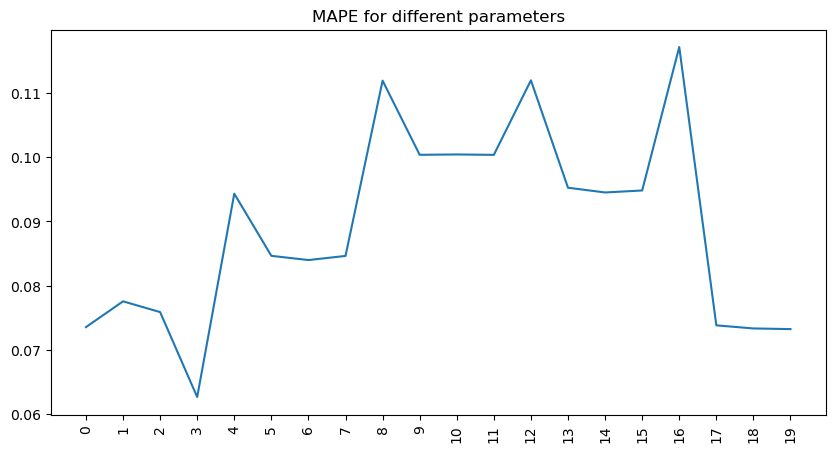

In [48]:
# plotting the mape for the different parameters
plt.figure(figsize=(10, 5))
plt.plot(tuning_results['mape'])
plt.xticks(range(len(tuning_results)), tuning_results.index, rotation=90)
plt.title('MAPE for different parameters')
plt.show()


In [49]:
# Find the best parameters
best_params = all_params[np.argmin(mapes)]
best_params

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}

Now, you can go back to your custom model and update the parameters accordingly! 

Well done! 

ps: Do you think the Prophet model can outperform the naive forecaster for stock price? :)